# Feature Engineering Overview
In our previous tutorials, we only brushed upon features and how to handle them. In this overview we'll take a practical approach to learning about feature engineering. The things we will focus on are:
- Develop a baseline model for comparing performances on models with more/different features.
- Encode categorical features so model can make better use of the information.
- Generate new features to provide more information for the model.
- Select specific features to reduce overfitting and increase prediction speed.

In the main exercise, we'll be using the 'TalkingDataAdTracking' kaggle competition dataset. The goal of this dataset is to predict if a user will download an app after clicking through an ad. For learning purposes we'll drop 99% of negative records (negative meaning the app wasn't downloaded) to make the target more balanced.

[1. Baseline Model](#baseline)  
[2. Categorical Encodings](#encode)  
[3. Feature Generation](#generate)  
[4. Feature Selection](#select)

#### Notes for self:
- **kst** is the raw imported data
- **kst_data** is timestamp encoded
- **base_data** is timestamp and label encoded

<a id='baseline'></a>
## 1. Baseline Model
In this overview we'll be using Kickstarter data.

### Kickstarter Warmup (review)

In [1]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
from termcolor import colored, cprint # colored prints
from my_modules import data_imports as data
cprint('Imported Modules', 'green')

Imported Modules


In [2]:
kst_data = data.import_kickstarter_2018_data()
kst_data.head(10)


Kickstarter 2018 data imported


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US,453.00,453.00,25000.00
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,6240.57,65000.00


Looking at this data, let's try to predict whether or not a Kickstarter project will succeed or not. To build teach our model, we can use the *state* column as our outcome. To predict this outcome, we can use features such as category, currency, funding goal, country, and when it was launched.

### Preparing target column
First, let's look at project states and convert them into something we can use as targets in a model. Remember that model's don't like to work with strings, and our outcome data is categorical.

In [3]:
# pd.unique(kst_data.state)
# kst_data.groupby('state')['ID'].count()
kst_data.groupby('state')['ID'].nunique()

state
canceled       38779
failed        197719
live            2799
successful    133956
suspended       1846
undefined       3562
Name: ID, dtype: int64

So we see that our dataset has 6 unique states, with mostly failed and successful outcomes.

Since our priority in this quick review is not data cleaning, we'll just go a long with this simple cleansing:
- Drop projects that are "live"
- Counting successful as ```outcome = 1```
- Combining all other states as ```outcome = 0```

In [4]:
# Drop live projects
kst_data = kst_data.query('state != "live"')

# Add the 'outcome' column with "successful == 1", everything else 0
kst_data = kst_data.assign(outcome=(kst_data['state'] == 'successful').astype(int))
kst_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,outcome
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00,0


### Converting Timestamps
Now that we have our outcome all setup and ready, it's time to handle dates. Let's convert the *launched* feature into something more categorical that our model can understand. We imported both *deadline* and *launched* as python Timestamp objects, so we can use the ```.dt.``` attribute on the timestamp column to get the times. 

In [5]:
# Note that this below syntax doesn't work on a single Timestamp object. dt must be used on a column
#    kst_data['launched'][0].dt

kst_data = kst_data.assign(
    hour=kst_data.launched.dt.hour,
    day=kst_data.launched.dt.day,
    month=kst_data.launched.dt.month,
    year=kst_data.launched.dt.year
)
kst_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,outcome,hour,day,month,year
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,0,12,11,8,2015
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,0,4,2,9,2017
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,0,0,12,1,2013
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,0,3,17,3,2012
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00,0,8,4,7,2015


### Prepping categorical variables
Now we that both our outcome AND timestamp data setup, it's time to get our other categorical variables in check! For our model, we'll be using *category*, *currency*, and *country*, which all need to be converted into integer representations. We'll use scikit-learn's ```LabelEncoder``` for this.

In [6]:
# print(kst_data.groupby('category')['ID'].nunique())
# print(kst_data.groupby('currency')['ID'].nunique())
# print(kst_data.groupby('country')['ID'].nunique())

In [7]:
from sklearn.preprocessing import LabelEncoder

cat_features = ['category', 'currency', 'country']
encoder = LabelEncoder()

# Apply the label encoder to each column
encoded_kst = kst_data[cat_features].apply(encoder.fit_transform)
encoded_kst.head(10)

,category,currency,country
0,108,5,9
1,93,13,22
2,93,13,22
3,90,13,22
4,55,13,22
5,123,13,22
6,58,13,22
7,41,13,22
8,113,13,22
9,39,13,22


Great! Now let's gather all of the columns we're using for this model into a new, clean little dataframe. Because our original dataframe and our encoded dataframe have the same index, we can ```join``` them together easily.

In [8]:
# kst_data has our hand-encoded hour, day, month, year, and outcome while 'encoded' has the labelencoded data. They both have the same index, so join join join!
base_data = data = kst_data[['goal', 'hour', 'day', 'month', 'year', 'outcome']].join(encoded_kst)
data.head()

,goal,hour,day,month,year,outcome,category,currency,country
0,1000.0,12,11,8,2015,0,108,5,9
1,30000.0,4,2,9,2017,0,93,13,22
2,45000.0,0,12,1,2013,0,93,13,22
3,5000.0,3,17,3,2012,0,90,13,22
4,19500.0,8,4,7,2015,0,55,13,22


### Creating training, validation, and test splits
Ain't our data pretty? Now that's it's ready to go, it's time to split up our data into training, validation and test splits! Since this is just a quick review, let's take a simple approach just use slices of our data. We'll use 10% of the data as validation, 10% for testing, and 80% for training.

**Note:** For python beginners (like me), there are extra steps/comments below to explain the indexing in the end

In [9]:
valid_fraction = 0.1
valid_size = int(len(data) * valid_fraction)

print("len of data: {}".format(len(data)))
print("valid size: {}".format(valid_size))
# The below indexing is a little confusing, so let's analyze it
# We need 80% of the set for training
print("80% of the dataset: {}".format(round(len(data) * 0.8)))
# This comes out to 300689, which is a difference of...
print( "Full data size - 80% data size: {}".format(round(len(data) - (len(data) * 0.8))))
# 75172! ... hmmmmmm now why are we using 2 * valid_size below?
print("valid_size doubled: {}".format(valid_size * 2))
# They're the same!!! valid_size * 2 === the difference from above!
# Oh ya.... valid_fraction = 0.1, so 100% - (10% * 2) = 80% .... I see

# Remember that python uses the colon as [start:end] accessor, and using negatives gives us the opposite, so [:1] is from start to the first element, and [:-1] is from the start, to the end-1

# start : end - (valid_size * 2), [0 : 375862 - 75173]
train = data[:-2 * valid_size]
# end - (valid_size*2) : end - valid_size, [375862 - 75173 : 375862 - 37586]
valid = data[-2 * valid_size:-valid_size]
# end - valid_size : end, 375862 - 37586 : 375826]
test = data[-valid_size:]

print("Length of train/valid/test: {}/{}/{}".format(len(train), len(valid), len(test)))

len of data: 375862
valid size: 37586
80% of the dataset: 300690
Full data size - 80% data size: 75172
valid_size doubled: 75172
Length of train/valid/test: 300690/37586/37586


In general, we want to be careful that each data set has the same proportion of the target classes (keep spliced data balanced). Let's print out the fraction of successful outcomes from each dataset to confirm:

In [10]:
# In the above block, we used traditional Python3 string formatting.
# Below, we use the new 3.6 F-strings!
# The below statement would most similary equal:
#   print("Outcome fraction = {:.4f}".format(each.outcome.mean()))

for each in [train, valid, test]:
    print(f"Outcome fraction = {each.outcome.mean():.4f}")

Outcome fraction = 0.3570
Outcome fraction = 0.3539
Outcome fraction = 0.3542


As we can see, each splice has around 35% true outcomes, likely because the data was well randomized beforehand. If this weren't the case, we could have used a helpful sklearn method: ```sklearn.model_selection.StratifiedShuffleSplit```.

### Training a LightGBM model
In previous examples, we used Random Regression Trees and XGBoost. This time around, we'll be using a *LightGBM* model. This is a tree-based model that typically provides the best performance, even compared to XGBoost. This time around our model won't be very optimized (as this is just a quick review) but we'll still see improvement through our feature engineering.

In [11]:
# if lightgbm can't be found, run the following command (if using conda)
#   conda install -c conda-forge lightgbm
import lightgbm as lgb

feature_cols = train.columns.drop('outcome')

# Read the docs on lightgbm for more info on the parameters
dtrain = lgb.Dataset(train[feature_cols], label=train['outcome'])
dvalid = lgb.Dataset(valid[feature_cols], label=valid['outcome'])

param = {'num_leaves' : 64, 'objective':'binary'}
param['metric'] = 'auc'
num_round = 1000
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10, verbose_eval=False)
print(colored("Good to go!", 'green'))

Good to go!


### Making predictions & evaluating the model
Now that we got the model all setup and trained, let's make some predictions on the test set with the model and see how it performs.

In [12]:
from sklearn import metrics
ypred = bst.predict(test[feature_cols])
score = metrics.roc_auc_score(test['outcome'], ypred)

print(f"Test AUC score: {score}")

Test AUC score: 0.747615303004287


And that's it for the basic baseline! Now we can move on engineering our features further.

<a id='encode'></a>
## 2. Categorical Encodings
Now that we have a nice lil baseline model, it's time to engineer it a little more. In a previous lesson, Intermediate Machine Learning, we learned about one-hot encoding and in this overview we used basic label coding above. Now we'll learn about a few more encodings, specifically:
- Count Encoding
- Target Encoding
- Singular Value Decomposition

In [13]:
# Let's define some helper function for testing our encodings. It'll be based off of lightgbm and data prep from above
#  - Helper functions defined in 'feature_engineering.py'
from my_modules import feature_engineering as fe
train, valid, _ = fe.get_kickstarter_splits(base_data)
bst = fe.train_kickstarter_model(train, valid)

Training model...
Validation AUC score: 0.7467


### Count Encoding
Count encoding replaces each categorical value with the number of times it appears in the dataset. For this encoding, we'll use *categorical-encodings* package, specifically ```CountEncoder```. This encoder and the others in *categorical-encodings* work like scikit-learn transformers with ```.fit``` and ```.transform``` methods.


In [14]:
# category_encoders conda install:
#   $ conda install -c conda-forge category_encoders
import category_encoders  as ce
cat_features = ['category', 'currency', 'country']
count_enc = ce.CountEncoder()
# kst_data from above, after timestamp encoding, pre basic encoding
count_encoded = count_enc.fit_transform(kst_data[cat_features])

category_data = base_data.join(count_encoded.add_suffix("_count"))

# Training and testing
train, valid, _ = fe.get_kickstarter_splits(category_data)
bst = fe.train_kickstarter_model(train, valid)

Training model...
Validation AUC score: 0.7486


A slight increase from 0.7467 -> 0.7486

### Target Encoding
Target encoding replaces a categorical value with the average value of the target for that value of the feature. For example, given the country value "CA", we would calculate the average outcome for all the rows with ```country == 'CA'```. This is often blended with the target probability over the entire dataset to reduce the variance of values with few occurences.

This technique uses the targets to create new features. So including the validation or test data in the target encodings would be a form of target leakage. We should only learn the target encodings from the training dataset only and apply it to the other datasets.

Much like ```CountEncoder```, we'll use ```TargetEncoder``` from *category_encoders*.

In [15]:
cat_features = ['category', 'currency', 'country']

target_enc = ce.TargetEncoder(cols=cat_features)

train, valid, _ = fe.get_kickstarter_splits(category_data)

target_enc.fit(train[cat_features], train['outcome'])

train = train.join(target_enc.transform(train[cat_features]).add_suffix('_target'))
valid = valid.join(target_enc.transform(valid[cat_features]).add_suffix('_target'))

train.head()
bst = fe.train_kickstarter_model(train, valid)

Training model...
Validation AUC score: 0.7491


Adding target encoding on top of count encoding has given us another increase, 
0.7486 -> 0.7491

### CatBoost Encoding
Finally we'll look at CatBoost encoding. CatBoost is similar to target encoding in that it's based on the target probability for a given value. However, with CatBoost, for each row, the target probability is calculated only from the rows before it.

In [16]:
cat_features = ['category', 'currency', 'country']
cat_boost = ce.CatBoostEncoder(cols=cat_features)

train, valid, _ = fe.get_kickstarter_splits(category_data)
cat_boost.fit(train[cat_features], train['outcome'])

train = train.join(cat_boost.transform(train[cat_features]).add_suffix("_cb"))
valid = valid.join(cat_boost.transform(valid[cat_features]).add_suffix("_cb"))

bst = fe.train_kickstarter_model(train, valid)

Training model...
Validation AUC score: 0.7492


With our current model, CatBoost only gave us a 0.0001 improvement over target encoding.

<a id='generate'></a>
## 3. Feature Generation
Creating new features from raw data is one of the best ways we can improve our models. For example, we can calculate the number of total projects in the last week and the duration of the fundraising period. Of course these new features will be different for all datasets, so it takes a bit of creativity. 

### Interactions
One of the easiest ways to create new features is by combining categorical variables.
For example, we combine the country *CA* and category *Music* and create a new value *CA_Music*. This new categorical feature can provide info about correlations between variables. This type of feature is typically called an interaction. In general we build interaction features from all pairs of categorical features. 

Be sure label encode the new combined feature!

In [17]:
# We use kst_data to get the interactions, and then labelencode them and append to base_data
interactions = kst_data['category'] + "_" + kst_data['country']
cprint('Interactions Head: ', 'cyan')
print(interactions.head(5))

label_enc = LabelEncoder()
interaction_data = base_data.assign(category_country=label_enc.fit_transform(interactions))
cprint('Appended Interaction Data', 'cyan')
interaction_data.head(5)
  

Interactions Head: 
0            Poetry_GB
1    Narrative Film_US
2    Narrative Film_US
3             Music_US
4      Film & Video_US
dtype: object
Appended Interaction Data


,goal,hour,day,month,year,outcome,category,currency,country,category_country
0,1000.0,12,11,8,2015,0,108,5,9,1900
1,30000.0,4,2,9,2017,0,93,13,22,1630
2,45000.0,0,12,1,2013,0,93,13,22,1630
3,5000.0,3,17,3,2012,0,90,13,22,1595
4,19500.0,8,4,7,2015,0,55,13,22,979


## Counting number of projects
Next we'll see how to the number of projects launched in the preceeding week for *each* record. We'll use the ```.rolling()``` method on a series with the *launched* column as the index. We'll first create the series using ```kst_data.launched``` as the index and ```ks_data.index``` as the values, then sort the times. Using a time series as the index allows us to define the rolling window size in terms of hours, days, weeks, etc.

In [18]:
# First create a Series with a timestamp index
launched = pd.Series(kst_data.index, index=kst_data.launched, name="count_7_days").sort_index()
launched.head(15)


launched
1970-01-01 01:00:00     94579
1970-01-01 01:00:00    319002
1970-01-01 01:00:00    247913
1970-01-01 01:00:00     48147
1970-01-01 01:00:00     75397
1970-01-01 01:00:00      2842
1970-01-01 01:00:00    273779
2009-04-21 21:02:48    169268
2009-04-23 00:07:53    322000
2009-04-24 21:52:03    138572
2009-04-25 17:36:21    325391
2009-04-27 14:10:39    122662
2009-04-28 13:55:41    213711
2009-04-29 02:04:21    345606
2009-04-29 02:58:50    235255
Name: count_7_days, dtype: int64

`One thing to note before continuing is that a few of the projects don't have valid start dates. For now we'll just ignore this, but in a real example these type of things should be cleansed out.

Now, with a timeseries as our index, we can use ```.rolling()``` to select time periods as the window. For example, ```launched.rolling('7d')``` creates a rolling window that contains all the data in the previous 7 days. The window contains the current record, so if we want to count all the *previous* projects but not the current one, we'll need to subtract 1. We'll plot the results to make sure it all looks right.

launched
1970-01-01 01:00:00     0.0
1970-01-01 01:00:00     1.0
1970-01-01 01:00:00     2.0
1970-01-01 01:00:00     3.0
1970-01-01 01:00:00     4.0
1970-01-01 01:00:00     5.0
1970-01-01 01:00:00     6.0
2009-04-21 21:02:48     0.0
2009-04-23 00:07:53     1.0
2009-04-24 21:52:03     2.0
2009-04-25 17:36:21     3.0
2009-04-27 14:10:39     4.0
2009-04-28 13:55:41     5.0
2009-04-29 02:04:21     5.0
2009-04-29 02:58:50     6.0
2009-04-29 04:37:37     7.0
2009-04-29 05:26:32     8.0
2009-04-29 06:43:44     9.0
2009-04-29 13:52:03    10.0
2009-04-29 22:08:13    11.0
Name: count_7_days, dtype: float64
/home/ttbot/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import 

Text(0.5, 1.0, 'Competitions in the last 7 days relative to current project')

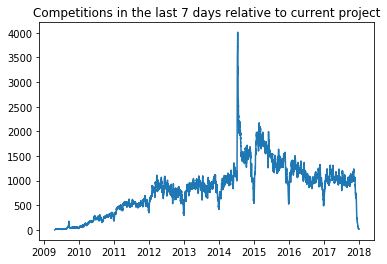

In [19]:
# help(launched.rolling)
count_7_days = launched.rolling('7d').count() - 1
print(count_7_days.head(20))

import matplotlib.pyplot as plt
# plot the count ignoring the first 7 records
plt.plot(count_7_days[7:])
plt.title("Competitions in the last 7 days relative to current project")

Very interesting spike there in 2014...

Anyways, now that we have the counts of projects that occured in the last 7 days relative to each project, we must adjust the index so we can join this new data with the training data.

In [20]:
# unlike a DataFrame, series don't have a set_index() function
print(launched)
count_7_days.index = launched.values
count_7_days = count_7_days.reindex(kst_data.index)
cprint('Reindexed count_7_days', 'cyan')
print(count_7_days.head(10))

# Now join this beautiful new feature onto the training data
cprint('New base_data', 'cyan')
base_data = base_data.join(count_7_days)

launched
1970-01-01 01:00:00     94579
1970-01-01 01:00:00    319002
1970-01-01 01:00:00    247913
1970-01-01 01:00:00     48147
1970-01-01 01:00:00     75397
                        ...  
2017-12-29 03:22:32    339929
2017-12-29 21:06:11     62039
2017-12-31 13:53:53     11463
2018-01-01 00:54:41    167940
2018-01-02 03:05:10     15604
Name: count_7_days, Length: 375862, dtype: int64
Reindexed count_7_days
0    1409.0
1     957.0
2     739.0
3     907.0
4    1429.0
5    1284.0
6    1119.0
7    1391.0
8    1043.0
9    3199.0
Name: count_7_days, dtype: float64
New base_data


### Time since the last project in the same category
Do projects in the same category compete for donors? If we're trying to fund a video game, and another game project in the same category was just launched, we might not get as much money, right? We can capture this by calculating the time since the last project launch in the same category.

A handy method for performing operations within groups is to use the ```.groupby()``` then ```transform()``` functions. The ```transform()``` method takes a function then passes a series or dataframe to the function for each group. This returns a dataframe with the same indices as the original dataframe. In our case, we'll perform a groupby on *category* and use transform to calculate the time differences for each category.

In [21]:
def time_since_last_project(series):
    # return the time in hours
    # diff calculates the difference of a series element compared with another (default previous)
    return series.diff().dt.total_seconds() / 3600.
df = kst_data[['category', 'launched']].sort_values('launched')
timedeltas = df.groupby('category').transform(time_since_last_project)
timedeltas.head(25)


,launched
94579,NaN
319002,NaN
247913,NaN
48147,NaN
75397,NaN
2842,0.000000
273779,NaN
169268,NaN
322000,NaN
138572,NaN


We get ```NaN``` values for projects that are the first in their category. We'll need to fill these in with something like the mean or median. We'll also need to reset the index again so we can merge into our training data.

In [22]:
# final time since last project
timedeltas = timedeltas.fillna(timedeltas.median()).reindex(base_data.index)
cprint('Fixed timedeltas', 'cyan')
print(timedeltas.head(10))
cprint('New base_data', 'cyan')
base_data = base_data.join(timedeltas)
base_data.head(10)

Fixed timedeltas
    launched
0  18.606111
1   5.592778
2   1.313611
3   0.635000
4  16.661389
5   2.629722
6   0.367500
7  12.286111
8  14.243611
9   0.174722
New base_data


,goal,hour,day,month,year,outcome,category,currency,country,count_7_days,launched
0,1000.0,12,11,8,2015,0,108,5,9,1409.0,18.606111
1,30000.0,4,2,9,2017,0,93,13,22,957.0,5.592778
2,45000.0,0,12,1,2013,0,93,13,22,739.0,1.313611
3,5000.0,3,17,3,2012,0,90,13,22,907.0,0.635000
4,19500.0,8,4,7,2015,0,55,13,22,1429.0,16.661389
5,50000.0,13,26,2,2016,1,123,13,22,1284.0,2.629722
6,1000.0,18,1,12,2014,1,58,13,22,1119.0,0.367500
7,25000.0,20,1,2,2016,0,41,13,22,1391.0,12.286111
8,125000.0,18,24,4,2014,0,113,13,22,1043.0,14.243611
9,65000.0,21,11,7,2014,0,39,13,22,3199.0,0.174722


### Transforming numerical features
The distribution of the values in *goal* shows that most projects have goals less than 5000 USD. However, there is a long tail of goals going up to $100,000. Some models work better when features are normally distributed, so it might help to transform the goal values. Common choices for this are the sqrt and natural logarithm. These transformations can also help constrain outliers.

Let's transform the goal feature using the sqrt and log functions and graph it to show the changes.

Text(0.5, 1.0, 'Goal')

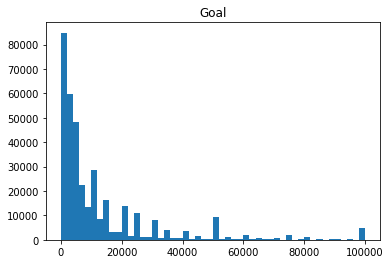

In [23]:
plt.hist(kst_data.goal, range=(0, 100000), bins=50)
plt.title('Goal')

Text(0.5, 1.0, 'Sqrt(Goal)')

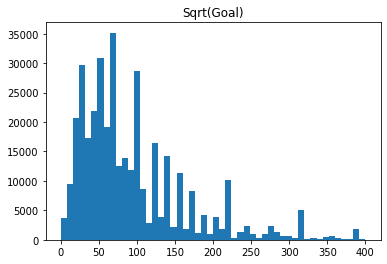

In [24]:
import numpy as np
plt.hist(np.sqrt(kst_data.goal), range=(0,400), bins=50)
plt.title('Sqrt(Goal)')

Text(0.5, 1.0, 'Log(Goal)')

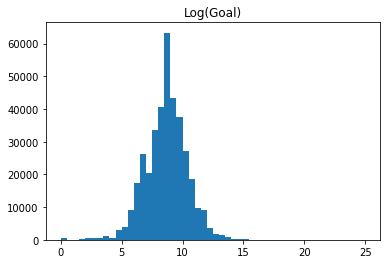

In [25]:
plt.hist(np.log(kst_data.goal), range=(0,25), bins=50)
plt.title('Log(Goal)')

The log transformation won't actually help our model since tree-based models are scale invariant (regardless of how much we zoom in or out, it will all look the same). However, this would help if we had a linear model or neural network.

Other transformations include squares and other powers, exponentials, etc. These might help the model discriminate, like ther kernel trick for SVMs. It takes a bit of experimentation to see what works. One method is to create a bunch of new features and later choose the the best ones with feature selection algorithms.

<a id='select'></a>
## 4. Feature Selection
Often we'll have hundreds or thousands of features after various encodings and feature generations. This can lead to two main problems. 
First, the more features we have, the more likely we will overfit to the training and validation sets. This will cause our model to perform worse at generalizing to new data.

Secondly, the more features we have, the longer it will take to train our model and optimize hyperparameters. Also, when building user-facing products, we'll want to make inference as fast as possible. Using fewer features can speed up inference at the cost of predictive performance.

To help with these issues, we'll want to use feature selection techniques to keep the most informative features for our model.

Let's get out data for this section setup.

In [26]:
from itertools import combinations
# To follow along with the kaggle tutorial, let's re-encode and do a bit of review
# Timestamped data
# kst_data

# Label Encoding
cat_features = ['category', 'currency', 'country']
lab_encoder = LabelEncoder()
encoded = kst_data[cat_features].apply(lab_encoder.fit_transform)

data_cols = ['goal', 'hour', 'day', 'month', 'year', 'outcome']
baseline = kst_data[data_cols].join(encoded)

# Interactions
interactions = pd.DataFrame(index=kst_data.index)
for col1, col2 in combinations(cat_features, 2):
    new_col_name = '_'.join([col1, col2])
    # convert to strings and combine
    new_values = kst_data[col1].map(str) + "_" + kst_data[col2].map(str)
    interactions[new_col_name] = lab_encoder.fit_transform(new_values)
baseline = baseline.join(interactions)

# last 7 days of projects in categories
launched = pd.Series(kst_data.index, index=kst_data.launched, name='count_7_days').sort_index()
count_7_days = launched.rolling('7d').count() - 1
count_7_days.index = launched.values
count_7_days = count_7_days.reindex(kst_data.index)

baseline = baseline.join(count_7_days)

# time since last project
df = kst_data[['category', 'launched']].sort_values('launched')
timedelt = df.groupby('category').transform(time_since_last_project)
timedelt = timedelt.fillna(timedelt.max())

baseline = baseline.join(timedelt.rename({'launched':'time_since_last_project'}, axis=1))
baseline

,goal,hour,day,month,year,outcome,category,currency,country,category_currency,category_country,currency_country,count_7_days,time_since_last_project
0,1000.0,12,11,8,2015,0,108,5,9,1215,1900,18,1409.0,18.606111
1,30000.0,4,2,9,2017,0,93,13,22,1047,1630,31,957.0,5.592778
2,45000.0,0,12,1,2013,0,93,13,22,1047,1630,31,739.0,1.313611
3,5000.0,3,17,3,2012,0,90,13,22,1024,1595,31,907.0,0.635000
4,19500.0,8,4,7,2015,0,55,13,22,630,979,31,1429.0,16.661389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,50000.0,2,17,9,2014,0,39,13,22,447,699,31,1482.0,2.659167
378657,1500.0,3,22,6,2011,0,93,13,22,1047,1630,31,505.0,3.835833
378658,15000.0,19,1,7,2010,0,93,13,22,1047,1630,31,238.0,20.575278
378659,15000.0,18,13,1,2016,0,138,13,22,1546,2412,31,1100.0,0.614444


### Univariate Feature Selection
The simplest and fastest methods are based on univariate statistical tests. For each feature, we measure how strongly the target depends on the feature using a statistical test like x<sup>2</sup> or ANOVA.

From the scikit-learn feature selection module, ```feature_selection.SelectKBest``` returns the K best features given some scoring function. For our classification problem, the module provides three different scoring functions: x<sup>2</sup>, ANOVA F-value, and the mutual information score. The F-value measures the linear dependency between the feature variable and the target. This means the score might underestimate the relation between a feature and the target if the relationship is nonlinear. The mutual information score is nonparametric and so can capture nonlinear relationships.

With ```SelectKBest```, we define the number of features to keep, based on the score from the scoring function. Using ```.fit_transform(features, target)``` we get back an array with only the selected features.

In [27]:
from sklearn.feature_selection import SelectKBest, f_classif

feature_cols = baseline.columns.drop('outcome')

# Keep 5 features
selector = SelectKBest(f_classif, k=5)

X_new = selector.fit_transform(baseline[feature_cols], baseline['outcome'])
X_new

array([[2015.,    5.,    9.,   18., 1409.],
       [2017.,   13.,   22.,   31.,  957.],
       [2013.,   13.,   22.,   31.,  739.],
       ...,
       [2010.,   13.,   22.,   31.,  238.],
       [2016.,   13.,   22.,   31., 1100.],
       [2011.,   13.,   22.,   31.,  542.]])

The above example is actually an example of data leakage. The statistical tests were calculated using all of the data, including the validation and test sets. This could influence the features we keep, so we should test only on the training set.

In [28]:
feature_cols = baseline.columns.drop('outcome')
train, valid, _ = fe.get_kickstarter_splits(baseline)

# Keep 5 features
selector = SelectKBest(f_classif, k=5)

X_new = selector.fit_transform(train[feature_cols], train['outcome'])
X_new

array([[2.015e+03, 5.000e+00, 9.000e+00, 1.800e+01, 1.409e+03],
       [2.017e+03, 1.300e+01, 2.200e+01, 3.100e+01, 9.570e+02],
       [2.013e+03, 1.300e+01, 2.200e+01, 3.100e+01, 7.390e+02],
       ...,
       [2.011e+03, 1.300e+01, 2.200e+01, 3.100e+01, 5.150e+02],
       [2.015e+03, 1.000e+00, 3.000e+00, 2.000e+00, 1.306e+03],
       [2.013e+03, 1.300e+01, 2.200e+01, 3.100e+01, 1.084e+03]])

And the selected features have changed! Now we have our selected features, but it's only the feature values for the training set. To drop the rejected features from the validation and test sets, we need to figure out which columns in the dataset were kept with ```SelectKBest```. To do this, we can use ```.inverse_transform``` to get back an array with the shape of the original data.

In [29]:
# Get back the features we've kept, zero out all other features
selected_features = pd.DataFrame(selector.inverse_transform(X_new),
                                 index=train.index,
                                 columns=feature_cols)
selected_features.head()

,goal,hour,day,month,year,category,currency,country,category_currency,category_country,currency_country,count_7_days,time_since_last_project
0,0.0,0.0,0.0,0.0,2015.0,0.0,5.0,9.0,0.0,0.0,18.0,1409.0,0.0
1,0.0,0.0,0.0,0.0,2017.0,0.0,13.0,22.0,0.0,0.0,31.0,957.0,0.0
2,0.0,0.0,0.0,0.0,2013.0,0.0,13.0,22.0,0.0,0.0,31.0,739.0,0.0
3,0.0,0.0,0.0,0.0,2012.0,0.0,13.0,22.0,0.0,0.0,31.0,907.0,0.0
4,0.0,0.0,0.0,0.0,2015.0,0.0,13.0,22.0,0.0,0.0,31.0,1429.0,0.0


This returns a DataFrame with the same index and columns as the training set, but all the dropped columns are filled with zeros. We can find the selected columns by choosing features where the variance is non-zero.

In [30]:
# Dropped columns have values of all 0s, so var is 0, drop them
selected_columns = selected_features.columns[selected_features.var() != 0]

# Get the valid dataset with the selected features
valid[selected_columns].head()

,year,currency,country,currency_country,count_7_days
302896,2015,13,22,31,1534.0
302897,2013,13,22,31,625.0
302898,2014,5,9,18,851.0
302899,2014,13,22,31,1973.0
302900,2014,5,9,18,2163.0


### L1 regularization
Univariate methods consider only one feature at a time when making a selection decision. Instead, we can make our selection using all of the features by including them in a linear model with L1 regularization. This type of regularization (sometimes called Lasso) penalizes absolute magnitude of the coefficients, as compared to L2 (Ridge) regression which penalizes the square of the coefficients.

As the strength of regularization is increased, features which are less important for predicting the target are set to 0. This allows us to perform feature selection by adjusting the regularization parameter. We choose the parameter by finding the best performance on a hold-out set, or decide ahead of time how many features to keep.

For regression problems, we can use ```sklearn.linear_model.Lasso```, or ```sklearn.linear_model.LogisticRegression``` for classification. These can be used along with ```sklearn.feature_selection.SelectFromModel``` to select the non-zero coefficients. Otherwise, the code is similar to the univariate tests.


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

train, valid, _ = fe.get_kickstarter_splits(baseline)

X, y = train[train.columns.drop('outcome')], train['outcome']

# Set the regularization parameter C=1
logistic = LogisticRegression(C=1, penalty="l1", random_state=7).fit(X, y)
model = SelectFromModel(logistic, prefit=True)

X_new = model.transform(X)
X_new

/home/ttbot/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[1.000e+03, 1.200e+01, 1.100e+01, ..., 1.900e+03, 1.800e+01,
        1.409e+03],
       [3.000e+04, 4.000e+00, 2.000e+00, ..., 1.630e+03, 3.100e+01,
        9.570e+02],
       [4.500e+04, 0.000e+00, 1.200e+01, ..., 1.630e+03, 3.100e+01,
        7.390e+02],
       ...,
       [2.500e+03, 0.000e+00, 3.000e+00, ..., 1.830e+03, 3.100e+01,
        5.150e+02],
       [2.600e+03, 2.100e+01, 2.300e+01, ..., 1.036e+03, 2.000e+00,
        1.306e+03],
       [2.000e+04, 1.600e+01, 4.000e+00, ..., 9.200e+02, 3.100e+01,
        1.084e+03]])

Similar to univariate tests, we get back an array with the selected features. Again, we will want to convert these to a DataFrame so we can ge the selected columns.

In [41]:
# Get back the kept features as a DataFrame with dropped columns as all 0s
selected_features = pd.DataFrame(model.inverse_transform(X_new),
                                 index=X.index,
                                 columns=X.columns)

# Dropped columns have values of all 0s, keep other columns
selected_columns = selected_features.columns[selected_features.var() != 0]
valid[selected_columns].head()

,goal,hour,day,month,year,category,currency,country,category_currency,category_country,currency_country,count_7_days
302896,5000.0,16,12,6,2015,39,13,22,447,699,31,1534.0
302897,3700.0,1,8,7,2013,54,13,22,617,958,31,625.0
302898,5500.0,22,27,5,2014,90,5,9,1018,1584,18,851.0
302899,25000.0,5,29,7,2014,136,13,22,1529,2386,31,1973.0
302900,4800.0,13,5,8,2014,156,5,9,1735,2708,18,2163.0


In this case with the L1 parameter C=1, we're dorpping the *time_since_last_project* column.

In general, feature selection with L1 regularization is more powerful than univariate tests, but it can also be very slow when we have a lot of data and a lot of features. Univariate tests will be much faster on large datasets, but also will likely perform worse.